## I. Les imports 

In [1]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display 

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, title=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.savefig(title)
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, title=None, cmap=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, cmap=cmap)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [3]:
df_model = pd.read_csv('df_model2.csv')
df_model.set_index(df_model['customer_unique_id'], inplace= True)
df_model.drop('customer_unique_id', axis=1, inplace=True)
df_model = df_model[['recence','frequence','montant','review_score','by_credit','last_review','delay','mean_installment']]
df_model

,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,141.90,5.0,1.0,161.0,-5.0,8.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,27.19,4.0,0.0,171.0,-5.0,1.0
0000f46a3911fa3c0805444483337064,542.0,1,86.22,3.0,1.0,570.0,-2.0,8.0
0000f6ccb0745a6a4b88665a16c9f078,326.0,1,43.62,4.0,1.0,360.0,-12.0,4.0
0004aac84e0df4da2b147fca70cf8255,293.0,1,196.89,5.0,1.0,331.0,-8.0,6.0
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452.0,2,4134.84,5.0,1.0,475.0,-27.0,10.0
fffea47cd6d3cc0a88bd621562a9d061,267.0,1,84.58,4.0,0.0,287.0,-3.0,1.0
ffff371b4d645b6ecea244b27531430a,573.0,1,112.46,5.0,0.0,611.0,-30.0,1.0


# II. Etape fondamentale pour un algorithme non supervisé : Determiner le nombre de cluster idéal.

- ### a) méthode du coude 

/tmp/ipykernel_3067/1078846049.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


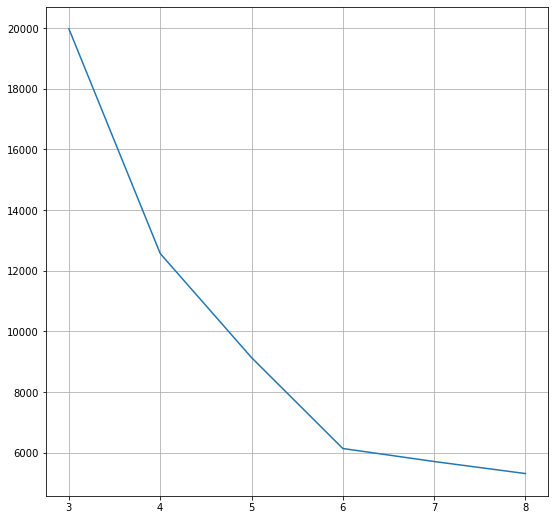

In [34]:
inertia = []
nb_cluster_max = 8
for z in range(3,nb_cluster_max+1):
    kmeans = KMeans(n_clusters = z)
    k_pipe = make_pipeline(MinMaxScaler(), kmeans)
    k_pipe.fit(df_model)
    inertia.append(k_pipe[1].inertia_)
    
x = np.arange(3,nb_cluster_max+1)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_xticks(ticks=np.arange(0,25,1))
ax.grid(b=True)
plt.plot(x, inertia)
plt.show()

- ### 6 Semble être un bon nombre de cluster 

- ### b) Score silhouette selon les différents clusters sans la PCA

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

kmeans = KMeans(n_clusters = 6)
k_pipe = make_pipeline(StandardScaler(), kmeans)
kmean_pca = make_pipeline( k_pipe, PCA(n_components=0.95))

segmentation_client = k_pipe.fit_transform(df_model)
segmentation_client_pca = kmean_pca.fit_transform(df_model)

df_model['kmean_split'] = kmean_pca[0][1].labels_
df_model['kmean_split'] += 1 

For n_clusters = 3 The average silhouette_score is : 0.5797090718155262
For n_clusters = 4 The average silhouette_score is : 0.5267397742796849
For n_clusters = 5 The average silhouette_score is : 0.47089678165394944
For n_clusters = 6 The average silhouette_score is : 0.4437610735631729
For n_clusters = 7 The average silhouette_score is : 0.4511684179346659
For n_clusters = 8 The average silhouette_score is : 0.45274302576210107


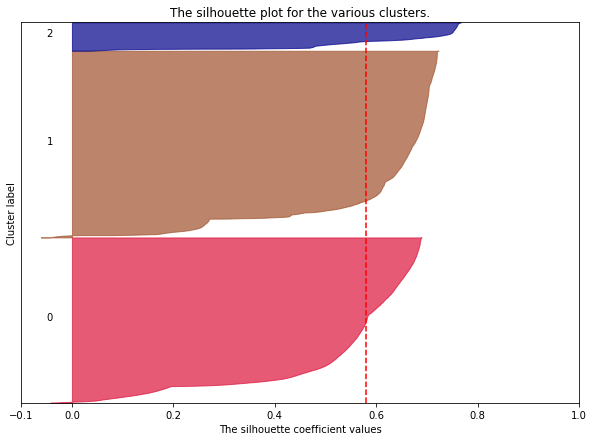

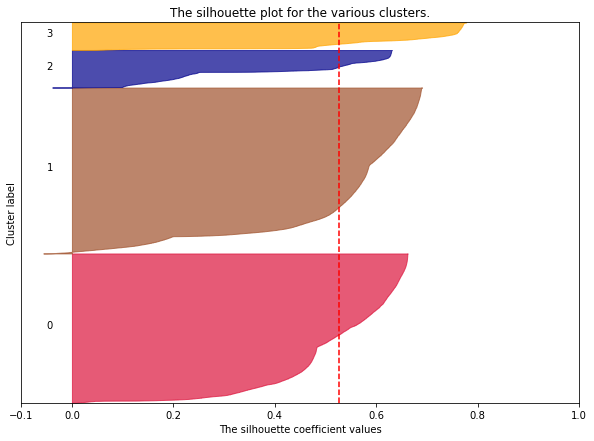

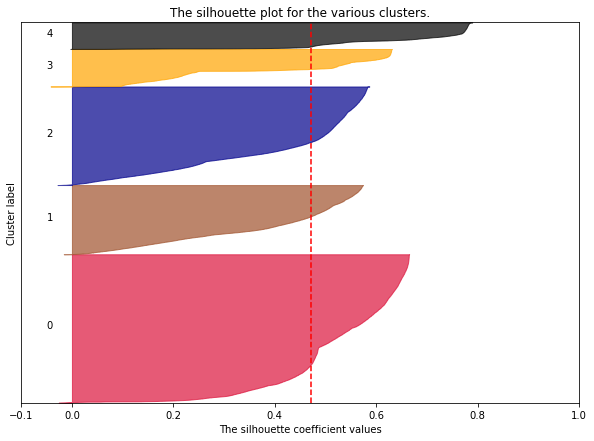

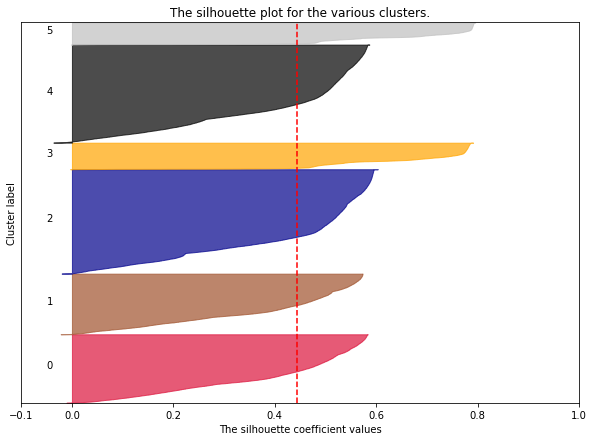

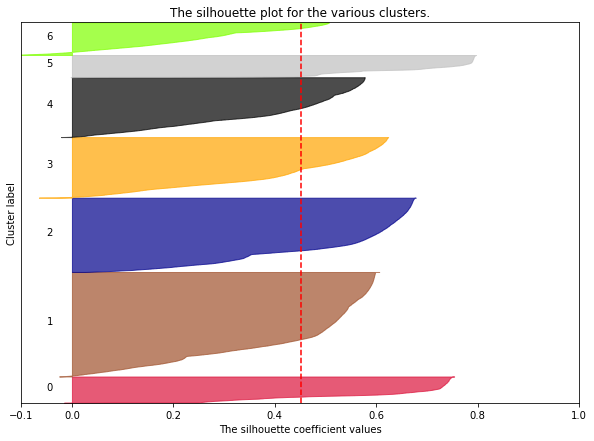

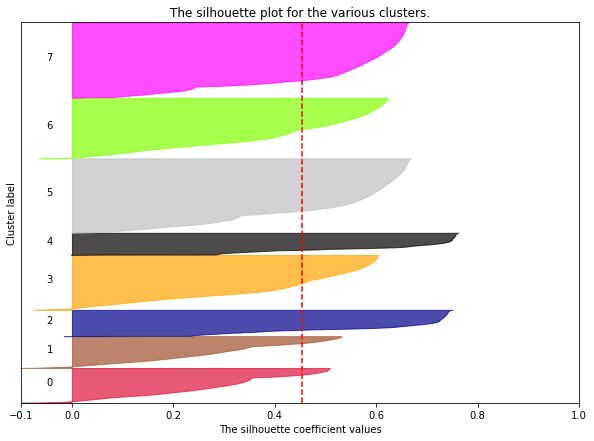

In [35]:
# Score silhouette selon les différents clusters avec la PCA


# défintions d'un code couleur pour chaque groupe

cmap = {
    0:'Crimson',
    1:'Sienna',
    2:'DarkBlue',
    3:'Orange',
    4:'Black',
    5:'Silver',
    6:'Chartreuse',
    7:'Fuchsia',
    8:'gray',
    9:'gray',
    10:'gray',
    11:'gray',
    12:'gray',
    13:'gray',
    14:'blue',
    15:'Crimson',
    16:'Sienna',
    17:'DarkBlue',
    18:'Orange',
}

silhouette = []
nb_cluster_max = 8

range_n_clusters = range(3,nb_cluster_max+1)

prep_X = segmentation_client

for n_clusters in range_n_clusters:
    # Création d'un subplot
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(prep_X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(prep_X)
    silhouette_avg = silhouette_score(prep_X, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Calcul du score silhouette
    sample_silhouette_values = silhouette_samples(prep_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color[i], edgecolor=color[i], alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

- ### b) Score silhouette selon les différents clusters avec la PCA

For n_clusters = 3 The average silhouette_score is : 0.5909336315729941
For n_clusters = 4 The average silhouette_score is : 0.5543081971959581
For n_clusters = 5 The average silhouette_score is : 0.4988451608679433
For n_clusters = 6 The average silhouette_score is : 0.43150076183264463
For n_clusters = 7 The average silhouette_score is : 0.4353763849960947
For n_clusters = 8 The average silhouette_score is : 0.45534108198208983


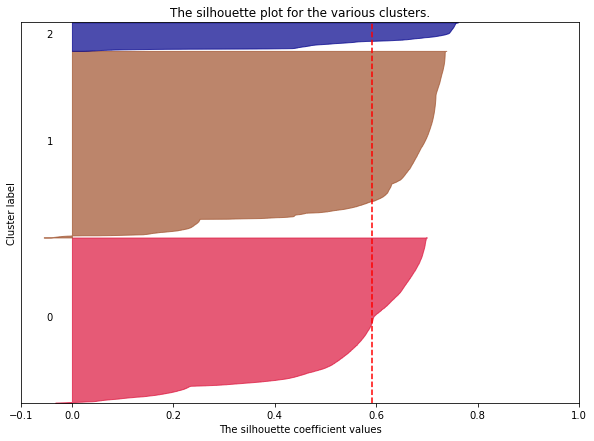

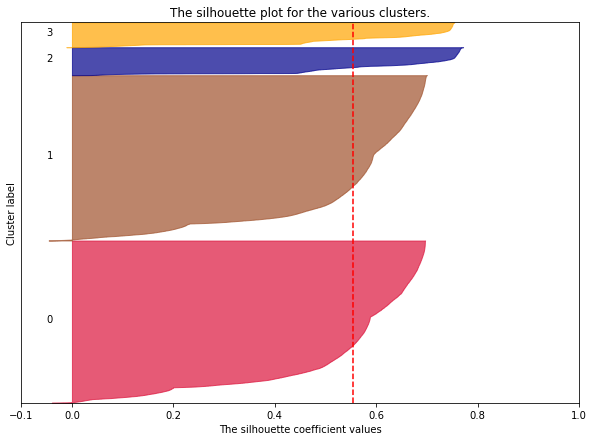

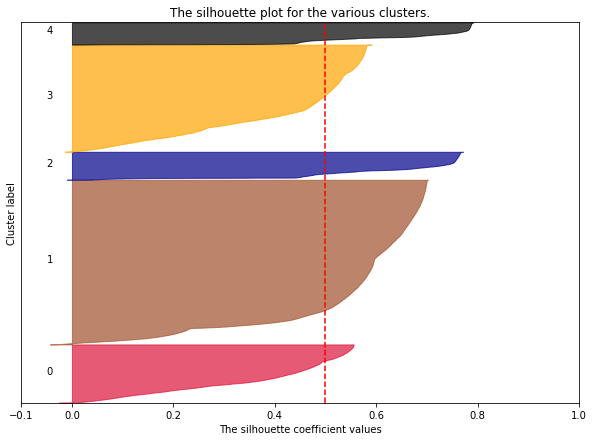

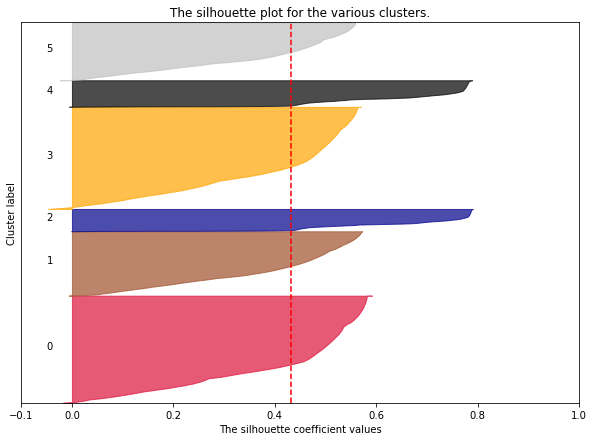

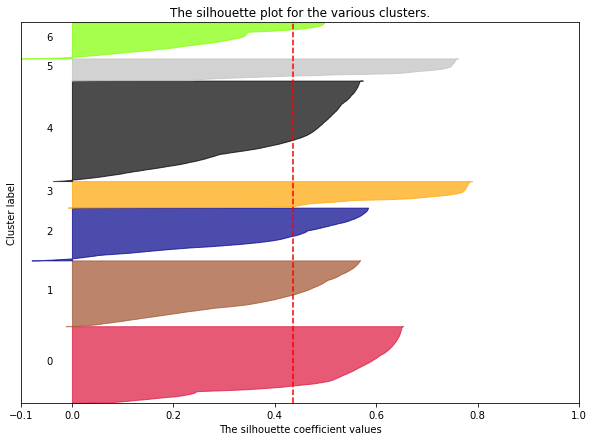

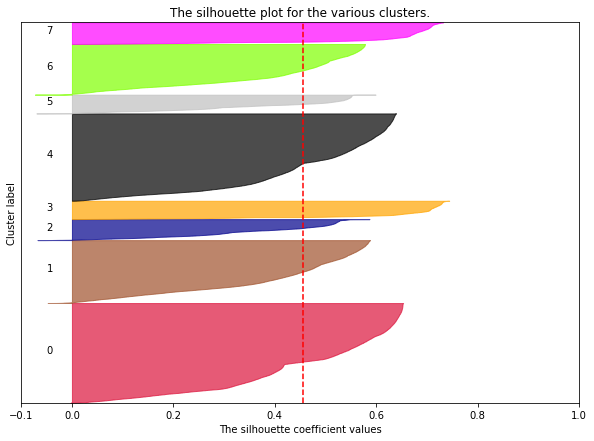

In [36]:
# Score silhouette selon les différents clusters avec la PCA


# défintions d'un code couleur pour chaque groupe

cmap = {
    0:'Crimson',
    1:'Sienna',
    2:'DarkBlue',
    3:'Orange',
    4:'Black',
    5:'Silver',
    6:'Chartreuse',
    7:'Fuchsia',
    8:'gray',
    9:'gray',
    10:'gray',
    11:'gray',
    12:'gray',
    13:'gray',
    14:'blue',
    15:'Crimson',
    16:'Sienna',
    17:'DarkBlue',
    18:'Orange',
}

silhouette = []
nb_cluster_max = 8

range_n_clusters = range(3,nb_cluster_max+1)

prep_X = segmentation_client_pca

for n_clusters in range_n_clusters:
    # Création d'un subplot
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(prep_X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(prep_X)
    silhouette_avg = silhouette_score(prep_X, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Calcul du score silhouette
    sample_silhouette_values = silhouette_samples(prep_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color[i], edgecolor=color[i], alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

- ### c) Visualisation de la courbe silhouette et du plis du coude 

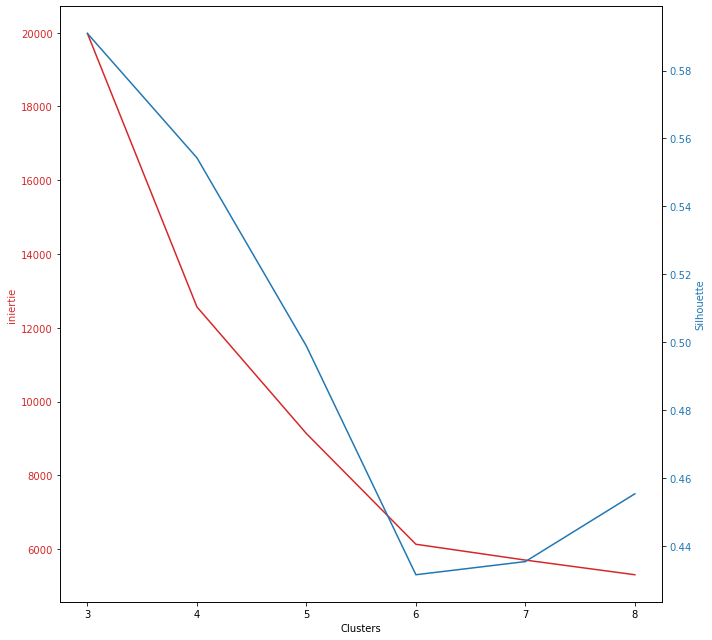

In [37]:
# Score silhouette + courbe d'inerties (données avec PCA) 
# # Création d'un grapique pour afficher l'inertie et le silhouette score sur un même axe X

fig, ax1 = plt.subplots(figsize=(10,9))
range_n_clusters = range(3,nb_cluster_max+1)

color = 'tab:red'
ax1.set_xlabel('Clusters')
ax1.set_ylabel('iniertie', color=color)
ax1.plot(list(range_n_clusters), inertia, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Deuxième axe qui partage l'axe x

color = 'tab:blue'
ax2.set_ylabel('Silhouette', color=color)  
ax2.plot(list(range_n_clusters), silhouette, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

- ### Mon score silhouette augmente un peu avec plus de cluster mais le score pour 6 cluster me convient aussi. 

- ### Je décide de garder 6 clusters et de faire mon kmean

# III. Instanciation du modele final et exploration des clusters 

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

kmeans = KMeans(n_clusters = 6)
k_pipe = make_pipeline(StandardScaler(), kmeans)
kmean_pca = make_pipeline( k_pipe, PCA(n_components=0.95))

segmentation_client = k_pipe.fit_transform(df_model)
segmentation_client_pca = kmean_pca.fit_transform(df_model)

df_model['kmean_split'] = kmean_pca[0][1].labels_
df_model['kmean_split'] += 1 


- ### a) Visualisation 

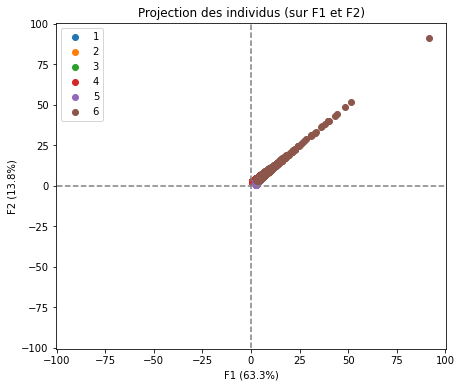

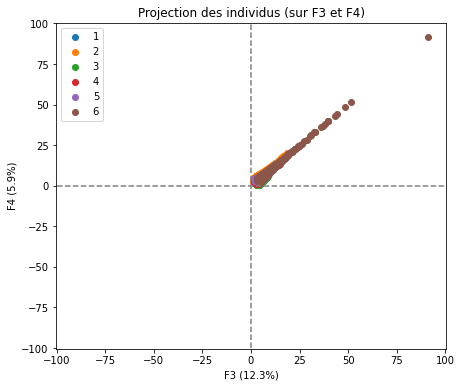

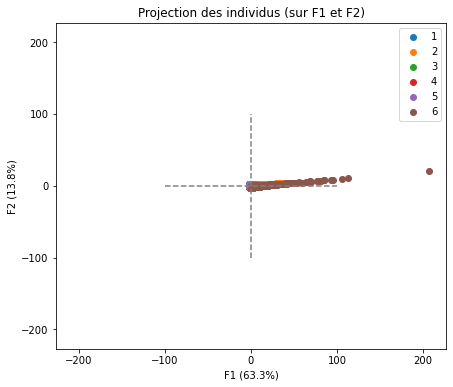

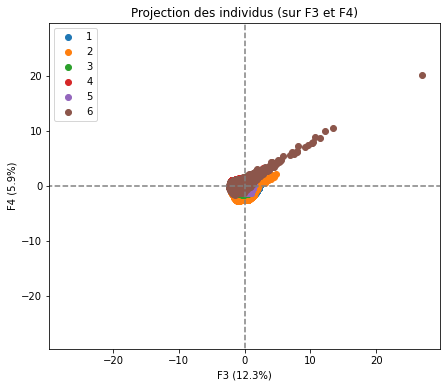

In [5]:
display_factorial_planes(X_projected=segmentation_client, n_comp=5, pca = kmean_pca[1], axis_ranks=[(0,1),(2,3),(4,5)], illustrative_var=df_model['kmean_split'])
display_factorial_planes(X_projected=segmentation_client_pca, n_comp=5, pca = kmean_pca[1], axis_ranks=[(0,1),(2,3),(4,5)], illustrative_var=df_model['kmean_split'])

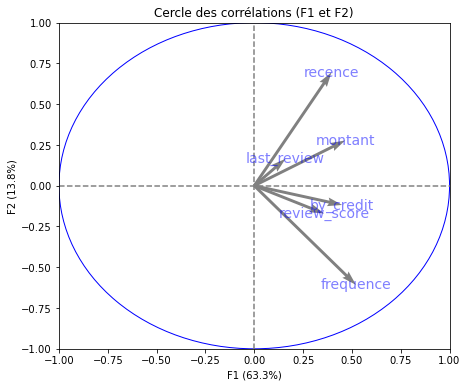

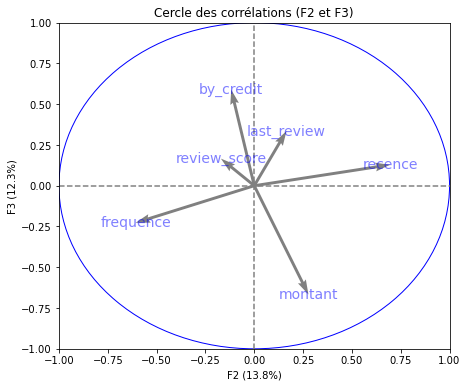

In [5]:
# Cercle des corrélations avec la PCA 
pcs = kmean_pca[1].components_
display_circles(pcs, 4, kmean_pca[1], [(0,1),(1,2),(3,4)], labels = df_model.columns , title='Cercles_corr')

- ### b) Exploration des clusters en détail

In [84]:
display(df_model.groupby('kmean_split').mean().describe())
display(df_model.groupby('kmean_split').mean())

,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,255.115351,1.372480,331.089699,3.856134,0.535659,294.954410,-11.272941,3.254194
std,121.968077,0.699434,438.944522,1.262372,0.446487,122.062904,5.371839,1.920135
min,132.700455,1.050920,112.549603,1.351906,0.006024,174.239845,-14.133165,1.010417
25%,153.668870,1.071812,131.023892,3.937861,0.144162,193.620562,-13.767872,1.478075
50%,230.656379,1.097140,174.824782,4.433307,0.602023,267.714031,-13.483747,3.651261
75%,362.637442,1.119636,180.964657,4.536070,0.912184,403.246002,-12.590267,4.842998
max,402.041395,2.799177,1224.904149,4.575246,0.996774,442.712490,-0.381969,5.218304


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
kmean_split,,,,,,,,
1,402.041395,1.067289,179.084714,4.426240,0.996774,442.712490,-14.133165,4.973199
2,401.005823,1.123216,117.843573,4.440375,0.010451,441.788489,-13.516435,1.020724
3,133.631673,1.085382,112.549603,4.575246,0.006024,175.557574,-12.303336,1.010417
4,213.780461,1.108897,170.564849,1.351906,0.545297,247.809524,-0.381969,2.850127
5,132.700455,1.050920,181.591305,4.567968,0.996663,174.239845,-13.451059,4.452395
6,247.532298,2.799177,1224.904149,3.775068,0.658748,287.618539,-13.851685,5.218304


In [85]:
for i in sorted(df_model['kmean_split'].unique()):
    print(f'-------------------- cluster n° {i} --------------------------------------------')
    display(df_model[df_model['kmean_split'] == i].iloc[:,:8])
    display(df_model[df_model['kmean_split'] == i].iloc[:,:8].describe())

-------------------- cluster n° 1 --------------------------------------------


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
0000f46a3911fa3c0805444483337064,542.0,1,86.22,3.0,1.0,570.0,-2.0,8.0
0000f6ccb0745a6a4b88665a16c9f078,326.0,1,43.62,4.0,1.0,360.0,-12.0,4.0
0004aac84e0df4da2b147fca70cf8255,293.0,1,196.89,5.0,1.0,331.0,-8.0,6.0
0005e1862207bf6ccc02e4228effd9a0,548.0,1,150.12,4.0,1.0,592.0,-28.0,3.0
0006fdc98a402fceb4eb0ee528f6a8d4,412.0,1,29.00,3.0,1.0,447.0,-12.0,2.0
...,...,...,...,...,...,...,...,...
ffedff0547d809c90c05c2691c51f9b7,522.0,1,32.42,5.0,1.0,559.0,-56.0,3.0
ffeefd086fc667aaf6595c8fe3d22d54,341.0,1,62.94,4.0,1.0,381.0,-8.0,3.0
fff1afc79f6b5db1e235a4a6c30ceda7,369.0,1,50.09,5.0,1.0,410.0,-16.0,4.0


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
count,17462.000000,17462.000000,17462.000000,17462.000000,17462.000000,17462.000000,17462.000000,17462.000000
mean,402.041395,1.067289,179.084714,4.426240,0.996774,442.712490,-14.133165,4.973199
std,92.587669,0.272221,157.898727,0.933743,0.039795,92.411021,7.561040,2.796428
min,238.000000,1.000000,20.080000,1.000000,0.333333,116.000000,-109.000000,2.000000
25%,322.000000,1.000000,77.570000,4.000000,1.000000,365.000000,-18.000000,3.000000
50%,394.000000,1.000000,130.905000,5.000000,1.000000,436.000000,-14.000000,4.000000
75%,471.000000,1.000000,217.765000,5.000000,1.000000,513.000000,-10.000000,7.000000
max,700.000000,4.000000,1246.420000,5.000000,1.000000,743.000000,42.000000,24.000000


-------------------- cluster n° 2 --------------------------------------------


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
00082cbe03e478190aadbea78542e933,288.0,1,126.26,5.0,0.0,330.0,-8.0,1.0
001147e649a7b1afd577e873841632dd,368.0,1,212.16,4.0,0.0,409.0,-14.0,1.0
00115fc7123b5310cf6d3a3aa932699e,590.0,1,76.11,4.0,0.0,633.0,-33.0,1.0
001926cef41060fae572e2e7b30bd2a4,382.0,2,182.42,4.0,0.0,426.0,-21.0,1.0
001a2bf0e46c684031af91fb2bce149d,431.0,1,36.73,4.0,0.0,480.0,-18.0,1.0
...,...,...,...,...,...,...,...,...
ffe9102bb78a76921ba0ff3c4659616a,451.0,1,416.36,4.0,0.0,494.0,-21.0,1.0
ffef0ffa736c7b3d9af741611089729b,462.0,1,139.07,5.0,0.0,505.0,-22.0,1.0
fff699c184bcc967d62fa2c6171765f7,367.0,1,55.00,4.0,0.0,409.0,-7.0,1.0


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
count,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000
mean,401.005823,1.123216,117.843573,4.440375,0.010451,441.788489,-13.516435,1.020724
std,96.490308,0.394971,120.059177,0.907791,0.071105,96.175086,7.489640,0.159519
min,252.000000,1.000000,10.070000,1.000000,0.000000,72.000000,-140.000000,1.000000
25%,316.000000,1.000000,50.847500,4.000000,0.000000,357.000000,-17.000000,1.000000
50%,387.000000,1.000000,79.845000,5.000000,0.000000,429.000000,-13.000000,1.000000
75%,476.000000,1.000000,138.142500,5.000000,0.000000,518.000000,-9.000000,1.000000
max,700.000000,5.000000,1323.790000,5.000000,0.666667,743.000000,38.000000,4.000000


-------------------- cluster n° 3 --------------------------------------------


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,27.19,4.0,0.0,171.0,-5.0,1.0
00050ab1314c0e55a6ca13cf7181fecf,136.0,1,35.38,4.0,0.0,181.0,-12.0,1.0
000949456b182f53c18b68d6babc79c1,133.0,1,82.05,4.0,0.0,173.0,-15.0,1.0
000d460961d6dbfa3ec6c9f5805769e1,239.0,1,36.68,5.0,0.0,287.0,-13.0,1.0
000e309254ab1fc5ba99dd469d36bdb4,70.0,2,78.42,3.0,0.0,108.0,-15.0,1.0
...,...,...,...,...,...,...,...,...
fff22793223fe80c97a8fd02ac5c6295,69.0,1,89.19,5.0,0.0,120.0,-18.0,1.0
fff3e1d7bc75f11dc7670619b2e61840,45.0,1,82.51,5.0,0.0,87.0,-9.0,1.0
fff7219c86179ca6441b8f37823ba3d3,250.0,1,265.80,4.0,0.0,281.0,-12.0,1.0


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
count,23752.000000,23752.000000,23752.000000,23752.000000,23752.000000,23752.000000,23752.000000,23752.000000
mean,133.631673,1.085382,112.549603,4.575246,0.006024,175.557574,-12.303336,1.010417
std,75.029223,0.324880,110.007247,0.699772,0.053891,72.868716,7.830274,0.107247
min,5.000000,1.000000,9.590000,1.000000,0.000000,0.000000,-71.000000,0.000000
25%,69.000000,1.000000,48.307500,4.000000,0.000000,113.000000,-17.000000,1.000000
50%,132.750000,1.000000,79.290000,5.000000,0.000000,175.000000,-12.000000,1.000000
75%,198.000000,1.000000,134.632500,5.000000,0.000000,238.000000,-7.000000,1.000000
max,459.000000,4.000000,1147.550000,5.000000,0.500000,316.000000,33.000000,4.000000


-------------------- cluster n° 4 --------------------------------------------


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
0005ef4cd20d2893f0d9fbd94d3c0d97,175.0,1,129.76,1.0,1.0,206.0,31.0,4.0
0012929d977a8d7280bb277c1e5f589d,321.0,1,155.65,1.0,0.0,369.0,-15.0,1.0
0019da6aa6bcb27cc32f1249bd12da05,204.0,1,87.71,1.0,0.0,254.0,-10.0,1.0
0025795df7a7d077c4c90162fa820085,41.0,2,428.16,1.0,1.0,91.0,-18.0,3.0
002aba8c1af80acacef6e011f9f23262,188.0,1,217.74,1.0,1.0,212.0,29.0,3.0
...,...,...,...,...,...,...,...,...
ffbbb45b560b9ff08bdde6786987c796,147.0,1,188.12,1.0,1.0,184.0,25.0,8.0
ffcb3eb07f2a033d45949fcecd160d98,114.0,1,206.08,2.0,1.0,159.0,-10.0,3.0
ffec490ab531184a483efe2eedd68908,31.0,1,57.98,1.0,0.0,73.0,9.0,1.0


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
count,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000,9835.000000
mean,213.780461,1.108897,170.564849,1.351906,0.545297,247.809524,-0.381969,2.850127
std,108.221999,0.350538,161.253036,0.686559,0.494954,106.316111,16.664255,2.504239
min,5.000000,1.000000,13.890000,1.000000,0.000000,27.000000,-34.000000,1.000000
25%,149.000000,1.000000,68.130000,1.000000,0.000000,183.000000,-11.000000,1.000000
50%,200.000000,1.000000,119.020000,1.000000,1.000000,231.000000,-3.000000,2.000000
75%,281.000000,1.000000,205.110000,1.000000,1.000000,312.000000,7.000000,4.000000
max,604.000000,5.000000,1354.090000,5.000000,1.000000,613.000000,188.000000,22.000000


-------------------- cluster n° 5 --------------------------------------------


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,141.90,5.0,1.0,161.0,-5.0,8.0
0004bd2a26a76fe21f786e4fbd80607f,151.0,1,166.98,4.0,1.0,202.0,-12.0,8.0
00090324bbad0e9342388303bb71ba0a,163.0,1,63.66,5.0,1.0,202.0,-8.0,3.0
000c8bdb58a29e7115cfc257230fb21b,265.0,1,29.00,5.0,1.0,304.0,-9.0,2.0
0010fb34b966d44409382af9e8fd5b77,182.0,1,61.80,4.0,1.0,212.0,2.0,6.0
...,...,...,...,...,...,...,...,...
ffeb904468642a1ce663a322629801cb,68.0,1,93.11,5.0,1.0,118.0,-16.0,3.0
ffec10ad4229ba46818560e1c8b40a68,151.0,1,135.72,5.0,1.0,189.0,-10.0,3.0
fff2ae16b99c6f3c785f0e052f2a9cfb,136.0,1,200.90,5.0,1.0,168.0,-21.0,8.0


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
count,22074.000000,22074.000000,22074.000000,22074.000000,22074.000000,22074.000000,22074.000000,22074.000000
mean,132.700455,1.050920,181.591305,4.567968,0.996663,174.239845,-13.451059,4.452395
std,75.314577,0.232069,153.687564,0.726474,0.040465,73.237411,8.219207,2.531363
min,5.000000,1.000000,20.190000,1.000000,0.500000,5.000000,-147.000000,1.500000
25%,68.000000,1.000000,84.650000,4.000000,1.000000,112.000000,-18.000000,2.000000
50%,130.000000,1.000000,138.115000,5.000000,1.000000,171.000000,-13.000000,4.000000
75%,197.000000,1.000000,215.580000,5.000000,1.000000,236.000000,-8.000000,6.000000
max,485.000000,3.000000,1159.650000,5.000000,1.000000,323.000000,28.000000,24.000000


-------------------- cluster n° 6 --------------------------------------------


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
customer_unique_id,,,,,,,,
00053a61a98854899e70ed204dd4bafe,187.0,2,838.36,1.000000,1.0,226.000000,-10.0,3.000000
005226be8d5b972d0f72b4e8a79f322b,155.0,1,1600.51,5.000000,1.0,203.000000,-19.0,10.000000
0085139b503668b3addcfe826d91be8d,216.0,2,1008.94,2.000000,1.0,255.000000,-6.0,5.000000
00a9fd000ff87bb48b989df819c418f5,167.0,4,259.40,5.000000,0.0,216.000000,-35.0,1.000000
00adeda9b742746c0c66e10d00ea1b74,300.0,2,4296.80,1.000000,1.0,347.000000,-21.0,10.000000
...,...,...,...,...,...,...,...,...
ff8892f7c26aa0446da53d01b18df463,343.0,3,396.88,2.666667,1.0,369.666667,11.0,7.333333
ff8eddc3ff272a5724e2ac6635cb7df2,64.0,2,1983.48,3.000000,1.0,92.000000,-35.0,8.000000
ffba9f9dff87b05e310ecc46c8591044,553.0,1,1626.83,5.000000,1.0,586.000000,-23.0,5.000000


,recence,frequence,montant,review_score,by_credit,last_review,delay,mean_installment
count,2186.000000,2186.000000,2186.000000,2186.000000,2186.000000,2186.000000,2186.000000,2186.000000
mean,247.532298,2.799177,1224.904149,3.775068,0.658748,287.618539,-13.851685,5.218304
std,144.143773,2.673614,961.376253,1.494895,0.451705,142.982197,9.316334,3.885374
min,8.000000,1.000000,19.000000,1.000000,0.000000,52.000000,-55.333333,1.000000
25%,132.000000,1.000000,659.947500,3.000000,0.000000,172.000000,-19.000000,1.000000
50%,236.000000,2.000000,1104.675000,4.333333,1.000000,276.000000,-14.000000,5.000000
75%,351.000000,4.000000,1521.540000,5.000000,1.000000,389.000000,-9.000000,9.000000
max,699.000000,54.000000,13664.080000,5.000000,1.000000,737.000000,96.000000,24.000000


# IV. Interpretation des clusters sur le pdf de presentation ([Ou clic ici](https://github.com/AyoubHaddou/Presentation_clustering_olist/blob/main/presentation_clusters.pdf)) 